In [1]:
import os

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from src.data import generate_data
from src.transformer import Transformer_F, in_context_loss
from src.utils import get_device
from src.theory import OptParamGenerator


matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams.update({"font.size": 16})
legend_fontsize = 12

In [ ]:
device = get_device("cuda")
train_seed = 0
test_seeds = list(range(10))

n_layer = 1
n_head = 1

# data
B_pt = 5000
B_ft = 5000
N_pt = 20
N_ft = 20
dataset_size_ft = 500_000
d = 5
x_std = 1.0
noise_std = np.sqrt(0.1)

# eval
B_eval = 100000

In [ ]:
model_eval = Transformer_F(n_layer, n_head, d).to(device)

gen = OptParamGenerator(d, device)

# theta0
torch.manual_seed(train_seed)
theta0 = torch.randn(d, device=device)
theta0 = theta0 / theta0.norm().clamp_min(1e-12)

# Pretrained model

In [ ]:
N_list  = list(range(0, 21))

N_pt_fix = 1000

d_list = [6, 11, 16, 21]

def eval_curve_for_params(model, params, theta0, d, noise_std):
    curves = []
    with torch.no_grad():
        model.allparam = params

    for seed in test_seeds:
        torch.manual_seed(seed)
        vals = []
        for N in N_list:
            z, y = generate_data(
                B_eval, N + 1, d, theta=theta0,
                x_std=x_std, noise_std=noise_std,
                use_prompt=True, device=device
            )
            with torch.no_grad():
                vals.append(in_context_loss(model, z, y).item())
        curves.append(torch.tensor(vals))
    return torch.stack(curves).mean(dim=0).cpu().numpy()


results_pretrained = {}
for temp_d in d_list:
    temp_model_eval = Transformer_F(n_layer, n_head, temp_d).to(device)

    gen_for_d = OptParamGenerator(temp_d, device)

    temp_theta0 = torch.randn(temp_d, device=device)
    temp_theta0 = temp_theta0 / temp_theta0.norm().clamp_min(1e-12)

    theory_params = gen_for_d.opt_params(temp_model_eval, "pretrain", m=N_pt_fix)
    results_pretrained[temp_d] = eval_curve_for_params(temp_model_eval, theory_params, temp_theta0, temp_d, 0.0)

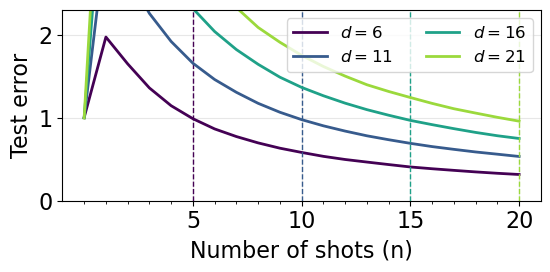

In [5]:
fig, ax = plt.subplots(figsize = (6, 3))
colors = cm.viridis(np.linspace(0, 0.85, len(d_list)))

for temp_d, c in zip(d_list, colors):
    ax.plot(N_list, results_pretrained[temp_d], color=c, lw=2, label=rf"$d={temp_d}$")
    ax.axvline(x=temp_d-1, color=c, lw=1, ls="--")

ax.set_xticks([5, 10, 15, 20])
ax.set_xticks(range(0, int(max(N_list)) + 1), minor=True)


ax.set_xlabel("Number of shots (n)")
ax.set_ylabel("Test error")
ax.set_ylim(0, 2.3)
ax.legend(ncol=2, fontsize=legend_fontsize, loc="upper right")
ax.grid(alpha=0.3); plt.tight_layout()
plt.savefig("figs/optimal_pretrained.pdf")
plt.show()

# Full fine-tuned model

In [6]:
N_list  = list(range(0, 41))
c_list_full = [0.3, 1, 3, 10, 30, 100]

def eval_curve_for_params(params):
    curves = []
    with torch.no_grad():
        model_eval.allparam = params

    for seed in test_seeds:
        torch.manual_seed(seed)
        vals = []
        for N in N_list:
            z, y = generate_data(B_eval, N + 1, d, theta=theta0, x_std=x_std, noise_std=noise_std, use_prompt=True, device=device)
            with torch.no_grad():
                vals.append(in_context_loss(model_eval, z, y).item())
        curves.append(torch.tensor(vals))
    return torch.stack(curves).mean(dim=0).cpu().numpy()


results_zs_finetune = {}
for cnt in c_list_full:
    theory_params = gen.opt_params(model_eval, "zs_finetune", theta0=theta0, cnt=cnt)
    results_zs_finetune[cnt] = eval_curve_for_params(theory_params)

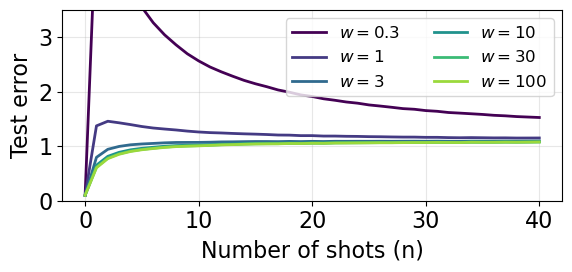

In [7]:
fig, ax = plt.subplots(figsize = (6, 3))
colors = cm.viridis(np.linspace(0, 0.85, len(c_list_full)))

for cnt, c in zip(c_list_full, colors):
    ax.plot(N_list, results_zs_finetune[cnt], color=c, lw=2, label=rf"$w={cnt}$")

ax.set_xlabel("Number of shots (n)")
ax.set_ylabel("Test error")
ax.set_ylim(0, 3.5)
ax.legend(ncol=2, fontsize=legend_fontsize, loc="upper right")
ax.grid(alpha=0.3); plt.tight_layout()
plt.savefig("figs/optimal_zs_finetune.pdf")
plt.show()



# Value-only fine-tuned model

In [8]:
N_list  = list(range(0, 41))

best_w = 0.66
w_list_v_only = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

def eval_curve_for_params(params):
    curves = []
    with torch.no_grad():
        model_eval.allparam = params

    for seed in test_seeds:
        torch.manual_seed(seed)
        vals = []
        for N in N_list:
            z, y = generate_data(B_eval, N + 1, d, theta=theta0, x_std=x_std, noise_std=noise_std, use_prompt=True, device=device)
            with torch.no_grad():
                vals.append(in_context_loss(model_eval, z, y).item())
        curves.append(torch.tensor(vals))
    return torch.stack(curves).mean(dim=0).cpu().numpy()

results_zs_finetune_v_only = {}
for cnt in w_list_v_only:
    theory_params = gen.opt_params(model_eval, "zs_finetune_v_only", theta0=theta0, cnt=cnt)
    results_zs_finetune_v_only[cnt] = eval_curve_for_params(theory_params)

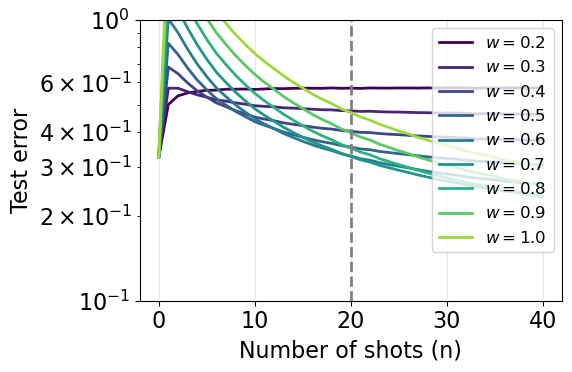

In [9]:
fig, ax = plt.subplots(figsize = (6, 4))
colors = cm.viridis(np.linspace(0, 0.85, len(w_list_v_only)))

for cnt, c in zip(w_list_v_only, colors):
    ax.plot(N_list, results_zs_finetune_v_only[cnt], color=c, lw=2, label=rf"$w={cnt}$")

ax.axvline(x=N_ft, color="gray", linestyle="--", lw=2)

ax.set_xlabel("Number of shots (n)")
ax.set_ylabel("Test error")
ax.set_yscale("log")
ax.set_ylim(0.1, 1.0)
ax.legend(fontsize=legend_fontsize, loc="upper right")
ax.grid(alpha=0.3); plt.tight_layout()
plt.savefig("figs/optimal_zs_finetune_v_only.pdf")
plt.show()

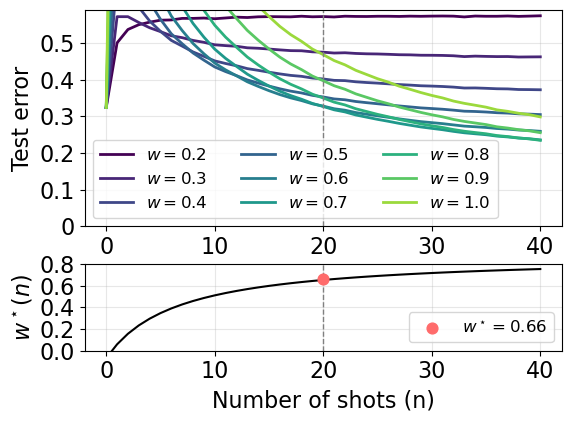

In [11]:
fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(6, 4.5), sharex=True, gridspec_kw={"height_ratios": [2.5, 1]})

# --- test error vs N for different c ---
colors = cm.viridis(np.linspace(0, 0.85, len(w_list_v_only)))
for cnt, c in zip(w_list_v_only, colors):
    ax_top.plot(N_list, results_zs_finetune_v_only[cnt], color=c, lw=2, label=rf"$w={cnt}$")

ax_top.axvline(x=N_ft, color="gray", linestyle="--", lw=1)
ax_top.set_ylabel("Test error")
# ax_top.set_yscale("log")
ax_top.set_ylim(0.0, 0.59)
ax_top.tick_params(axis="x", labelbottom=True)
ax_top.legend(ncol=3, fontsize=legend_fontsize)
ax_top.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))
ax_top.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, _: f"{y:g}"))
ax_top.grid(alpha=0.3)

# --- optimal c vs N ---
N_list = np.array(N_list)
best_w = (N_list+1) - (N_list+3+2*d) / (d+4)
best_w = best_w / (N_list+1+d + d*noise_std**2)

ax_bot.plot(N_list, best_w, color="black")
ax_bot.set_xlabel("Number of shots (n)")
ax_bot.set_ylabel(r"$w^\star(n)$")
ax_bot.axvline(x=N_ft, color="gray", linestyle="--", lw=1)
ax_bot.scatter(N_ft, best_w[N_ft+1], color="#FF6B6B", s=60, label=rf"$w^\star={best_w[N_ft+1]:.2f}$", zorder=5)

ax_bot.set_ylim(0.0, 0.8)
ax_bot.legend(fontsize=legend_fontsize, loc="lower right")
ax_bot.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))
ax_bot.grid(alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)

plt.savefig("figs/optimal_zs_finetune_v_only_with_c.pdf")
plt.show()